# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
grid = Grid.from_raster('../data/n30w100_con', data_name='dem')

In [3]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [4]:
grid.read_raster('../data/n30w100_dir', data_name='dir')

In [5]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [6]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [7]:
grid.resolve_flats('dem', out_name='inflated_dem')

In [8]:
dem = grid.view('inflated_dem', apply_mask=False, dtype=float)

In [9]:
def facet_flow(e0, e1, e2, d1=1, d2=1):
    s1 = (e0 - e1)/d1
    s2 = (e1 - e2)/d2
    r = np.arctan2(s2, s1)
    s = np.hypot(s1, s2)
    diag_angle    = np.arctan2(d2, d1)
    diag_distance = np.hypot(d1, d2)
    r[r < 0] = 0
    s[r < 0] = s1[r < 0]
    r[r > diag_angle] = diag_angle
    s[r > diag_angle] = ((e0 - e2)/diag_distance)[r > diag_angle]
    return r, s

In [10]:
inside = grid._inside_indices(dem)

In [11]:
inner_neighbors = grid._select_surround_ravel(inside, dem.shape).T

In [12]:
inner_neighbors = inner_neighbors[[2, 1, 0, 7, 6, 5, 4, 3]]

In [13]:
R = np.zeros((8, inside.size))
S = np.zeros((8, inside.size))

In [14]:
# I think the ordering of these might not be right
dirs = range(8)
e1s = [0, 2, 2, 4, 4, 6, 6, 0]
e2s = [1, 1, 3, 3, 5, 5, 7, 7]

for i, e1, e2 in zip(dirs, e1s, e2s):
    r, s = facet_flow(dem.flat[inside], dem.flat[inner_neighbors[e1, :]], dem.flat[inner_neighbors[e2, :]],
                      d1=78.0, d2=92.5)
    R[i] = r
    S[i] = s

In [15]:
S_max = np.max(S, axis=0)
k_max = np.argmax(S, axis=0)

In [16]:
ac = np.asarray([0, 1, 1, 2, 2, 3, 3, 4])
af = np.asarray([1, -1, 1, -1, 1, -1, 1, -1])

In [17]:
nR = np.zeros(inside.size)
nR = (af[k_max] * R[k_max, np.arange(R.shape[-1])]) + (ac[k_max] * np.pi / 2)
nR[S_max <= 0] = np.nan

In [18]:
z = np.zeros(dem.shape)
z[:] = np.nan

In [19]:
z[1:-1, 1:-1] = nR.reshape(dem.shape[0] - 2, dem.shape[1] - 2)

In [20]:
import cmocean

In [21]:
mapping = {
    64 : np.pi/2,
    128 : np.pi/4,
    1 : 0,
    2 : 7*np.pi/4,
    4 : 3*np.pi/2,
    8 : 5*np.pi/4,
    16 : np.pi,
    32 : 3*np.pi/4,
    255 : np.nan
}

s = pd.Series(grid.view('dir').ravel()).map(mapping)

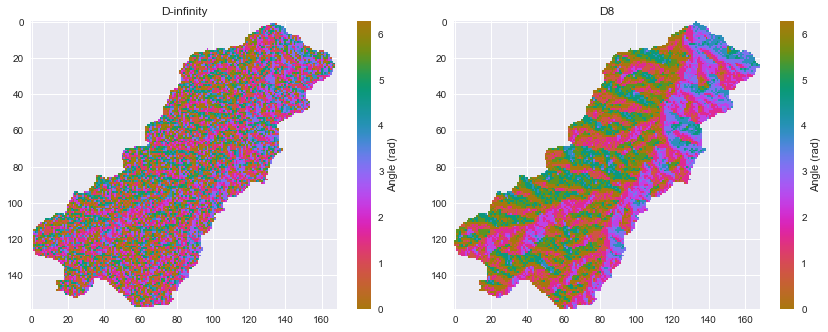

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
im0 = ax[0].imshow(np.where(grid.mask, z, np.nan), vmin=0, vmax=2*np.pi, cmap=cmocean.cm.phase, zorder=1)
im1 = ax[1].imshow(s.values.reshape(grid.shape), vmin=0, vmax=2*np.pi, cmap=cmocean.cm.phase, zorder=1)
plt.colorbar(im0, ax=ax[0], label='Angle (rad)')
plt.colorbar(im1, ax=ax[1], label='Angle (rad)')
ax[0].set_title('D-infinity')
ax[1].set_title('D8')
plt.tight_layout()

In [23]:
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4, 2*np.pi]
dig = np.digitize(z, angles)

In [24]:
def components(theta, offset=0):
    a = np.cos(theta - offset) - np.sin(theta - offset)
    b = np.sqrt(2) * np.sin(theta - offset)
    return a, b

In [25]:
a, b = components(np.pi/6)

In [26]:
# Verify using law of cosines
np.sqrt(a**2 + b**2 - 2*a*b*np.cos(3*np.pi/4))

1.0

In [27]:
c0 = np.asarray([0, 1, 128, 64, 32, 16, 8, 4, 2, 0])
c1 = np.asarray([0, 128, 64, 32, 16, 8, 4, 2, 1, 0])

In [28]:
fdir_0 = c0.flat[dig]
fdir_1 = c1.flat[dig]

In [29]:
self = grid
padshape = grid.shape
x, y = -97.294167, 32.73750
x, y = self.nearest_cell(x, y, grid.affine, grid.shape)
pour_point = np.ravel_multi_index(np.array([y, x]), grid.shape)
r_dirmap = np.array(dirmap)[[4, 5, 6, 7, 0, 1, 2, 3]].tolist()
pour_point = np.array([pour_point])

In [30]:
def catchment_search_dinf(cells):
    global collect
    global visited
    global fdir_0
    global fdir_1
    collect.extend(cells)
    visited.flat[cells] = True
    selection = self._select_surround_ravel(cells, padshape)
    next_idx = selection[np.where((~visited.flat[selection]) & 
                                  ((fdir_0.flat[selection] == r_dirmap) |
                                   (fdir_1.flat[selection] == r_dirmap)))]
    if next_idx.any():
        return catchment_search_dinf(next_idx)

In [31]:
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc')

In [32]:
accsort = np.argsort(grid.acc.ravel())[::-1]

In [33]:
n = []

for i in inside:
    collect = []
    visited = np.zeros(grid.shape, dtype=np.bool)
    pour_point = np.array([i])
    catchment_search_dinf(pour_point)
    numcells = np.unique(collect).size
    n.append(numcells)

In [34]:
max(n)

228

In [35]:
# Highest acc
inside[np.argmax(np.asarray(n))]

10848

In [36]:
collect = []
visited = np.zeros(grid.shape, dtype=np.bool)
pour_point = np.array([10848])
catchment_search_dinf(pour_point)

In [37]:
out = np.zeros(grid.shape)
out.flat[collect] = 1

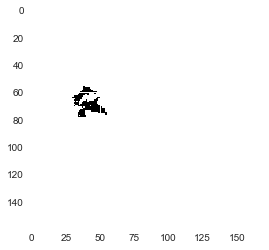

In [38]:
plt.imshow(out)